# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from msresist.parameter_tuning import kmeansPLSR_tuning
from msresist.plsr import plotMeasuredVsPredicted, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
ABC_mc = preprocessing(motifs=True, Vfilter=True, FCfilter=True, log2T=True)

header = ABC_mc.columns
treatments = ABC_mc.columns[2:12]

data = ABC_mc.iloc[:,2:12].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

In [3]:
ABC_mc

,peptide-phosphosite,Master Protein Descriptions,PC9,Erl,R428,Erl/R428,Erl+HGF,Erl+FGF,Erl+IGF,KO Erl,KO R428,KO Erl/R428,position
1,---MRyVASYL,60S acidic ribosomal protein P2,-0.041348,0.330638,0.079619,-0.287413,-0.230024,-0.550611,-0.398655,-0.141238,-0.088036,1.327068,Y3-p
2,---MtyAYLFK,Ras-related protein Rab-2B,0.633928,0.259916,-0.055945,-0.434915,0.208498,0.418103,0.471005,-0.675985,-0.459938,-0.364667,Y3-p
3,-MAKAyDHLFK,Ras-related protein Rab-13,0.541208,0.090077,-0.229873,-1.142080,0.287358,-0.069477,1.225244,-0.160944,-0.093620,-0.447893,Y5-p
5,-MARDyDHLFK,Ras-related protein Rab-35,0.356559,-0.176429,0.267839,-0.796749,0.275687,-0.194960,0.501464,-0.143006,0.196517,-0.286921,Y5-p
8,AAAIAyGLDRT,Heat shock 70 kDa protein 1A,0.431886,0.894781,0.373969,-0.304444,-1.203818,-0.086804,-0.276191,-0.184870,-0.155607,0.511098,Y183-p
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,YNGDYyRQGRI,Tyrosine-protein kinase receptor UFO,2.000649,1.825741,1.407761,0.059403,1.791506,1.472838,1.270572,-3.221904,-3.181840,-3.424725,Y703-p
715,YRIDHyLGKEM,Glucose-6-phosphate 1-dehydrogenase,0.859847,0.526724,0.082206,-1.119890,0.295326,-0.272845,-0.389873,0.040738,0.442742,-0.464974,Y202-p
717,YSRAKsPQPPV,Heterogeneous nuclear ribonucleoprotein U,-1.506732,-0.552407,-0.764941,-0.304817,0.035451,-0.012596,-1.148686,0.686723,1.223962,2.344042,S271-p
718,YTGQPsPRGLH,Mitotic interactor and substrate of PLK1,0.560768,0.916321,0.153097,-0.712320,-0.328744,-0.341950,-0.130217,-0.060099,-0.526681,0.469825,S78-p


### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

Define time-point of interest:

## 1. Cross-validation

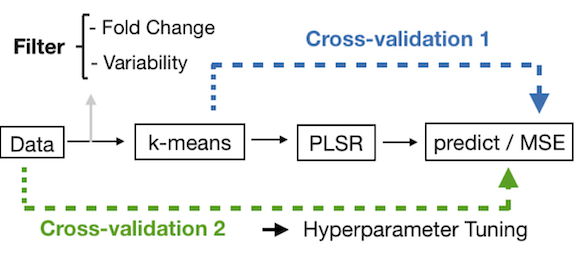

In [5]:
from IPython.display import Image
Image(filename='Model_pipeline.jpg')

### 1.1 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [6]:
ncl = 4

In [7]:
kmeans = MyOwnKMEANS(ncl).fit(data, Y_cv)
centers = kmeans.transform(data)

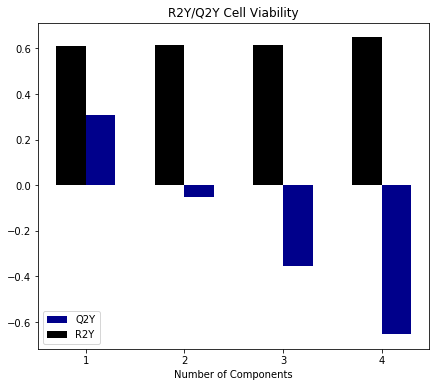

In [8]:
maxComp = ncl
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)

### 1.2 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [9]:
CVresults_max, CVresults_min, best_params = kmeansPLSR_tuning(data, Y_cv)
CVresults_min.nlargest(20, "mean_test_scores")

,#Clusters,#Components,mean_test_scores,mean_train_scores
14,6,1,-11.938073,-6.897019
2,3,1,-11.942946,-6.827024
5,4,1,-11.962488,-6.987018
20,7,1,-12.240186,-6.961131
9,5,1,-12.575552,-6.788890
65,12,1,-13.379221,-6.786231
90,14,1,-13.637811,-6.688182
27,8,1,-13.820906,-6.828705
1,2,2,-13.848831,-6.689196
54,11,1,-13.860881,-6.889036


## 2. Model Predicted vs Actual for best Hyperparameter Set

In [10]:
ncl, ncomp = 4, 2

### 2.1 With CV Strategy 1:

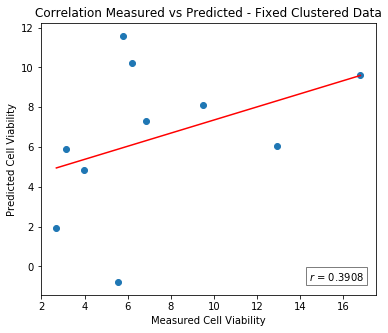

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plotMeasuredVsPredicted(ax, PLSRegression(ncomp), centers, Y_cv)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data");

### 2.2 With CV Strategy 2:

In [12]:
estimators = [('kmeans', MyOwnKMEANS(ncl)), ('plsr', PLSRegression(ncomp))]
kmeans_plsr = Pipeline(estimators)

In [13]:
X_scores, Y_scores = kmeans_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = kmeans_plsr.named_steps.plsr.x_loadings_[:, 0], kmeans_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = kmeans_plsr.named_steps.plsr.y_loadings_[:, 0], kmeans_plsr.named_steps.plsr.y_loadings_[:, 1]

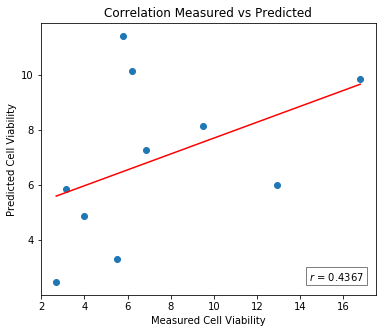

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, kmeans_plsr, data, Y_cv)

## 3. PLSR scores and loadings 

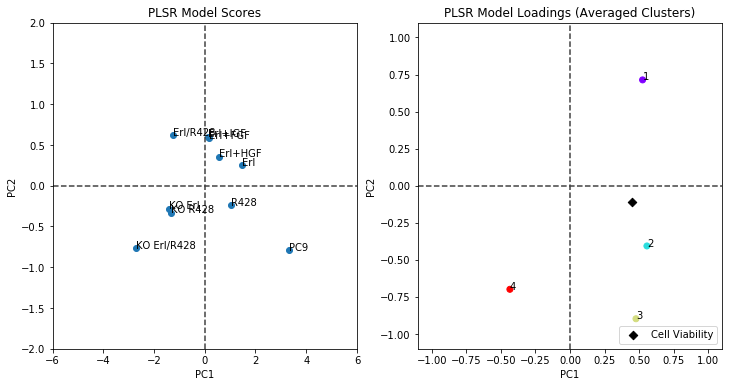

In [15]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-6, 6])
axs[0].set_ylim([-2, 2])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-1.1, 1.1])
axs[1].set_ylim([-1.1, 1.1]);

In [16]:
clustermembers = kmeans_plsr.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,Ras-related protein Rab-2B,---MtyAYLFK,Claudin-4,AAASNyV----,Ras-related protein Rab-35,-MARDyDHLFK,60S acidic ribosomal protein P2,---MRyVASYL
1,Ras-related protein Rab-13,-MAKAyDHLFK,Coactosin-like protein,ACRAAyNLVRD,Heat shock 70 kDa protein 1A,AAAIAyGLDRT,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR
2,Kinesin light chain 2,AEEVEyYYRRA,Protein tweety homolog 3,AHDSLyRVHMP,Kin of IRRE-like protein 1,AAGYPtYRLGY,Choline-phosphate cytidylyltransferase A,AAYDIsEDEED
3,Receptor tyrosine-protein kinase erbB-2,AENPEyLGLDV,Nucleophosmin,AKFINyVKNCF,DNA replication licensing factor MCM7,AANPAyGRYNP,Pyruvate kinase PKM,AEAAIyHLQLF
4,ATPase WRNIP1,AGEEHyNCISA,Receptor tyrosine-protein kinase erbB-3,APHVHyARLKT,Mitogen-activated protein kinase 13,ADAEMtGYVVT,Envoplakin,AEDAVyELQSK
...,...,...,...,...,...,...,...,...
147,NaN,NaN,NaN,NaN,Paxillin,YCEKDyHNLFS,NaN,NaN
148,NaN,NaN,NaN,NaN,Integrin beta-4,YGTHLsPHVPH,NaN,NaN
149,NaN,NaN,NaN,NaN,Glucose-6-phosphate 1-dehydrogenase,YRIDHyLGKEM,NaN,NaN
150,NaN,NaN,NaN,NaN,Mitotic interactor and substrate of PLK1,YTGQPsPRGLH,NaN,NaN


In [17]:
create_download_link(clustermembers, "check members")

#### Cluster Averages across Conditions